# Code to validate PIV analysis method
Code set using adrian et al. PIV <br>
Last updated: 08-25-17 <br>
Code Strucutre: <br>
-import libraries <br>
-run analysis codes <br>
-read in data <br>
- plot outer <br>
- plot inner <br>

In [2]:
import pandas as pd
import numpy as np
import PIV as piv
import time_series as ts
import time
import sys
import h5py
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import hotwire as hw
import imp

In [3]:
# import functions to be run
imp.reload(ts)
imp.reload(piv)
imp.reload(hw)
%run 'air_prop.py'
%run 'piv_outer.py'
%run 'piv_readin.py'
%run 'piv_inner.py'

In [4]:
## INITIAL CODE USED FOR READING IN
#Parameter set
date = 'adrian'
data_delimiter = ','
num_images = 48
sizex = 216
sizey = 86
walloffset = 0 #mm
side_error = 0
#determine file name
file_name = dict()
for j in range(1, num_images+1):
    file_name[j] = '/AMT00High' + str('{0:02}'.format(j)) + '.dat'
#list name of data set folders
base_name = dict()
#List the base name for each test to be read in and analyzed, names taken directly from folder
base_name[0] = 'data/AMT00HighReAll'

piv_readin(date, file_name, base_name, num_images, data_delimiter, sizex, sizey, walloffset, side_error)

Reading In: |██████████████████████████████████████████████████| 100.0% Complete
Done Read in!
Mask Found!
Data Saved!


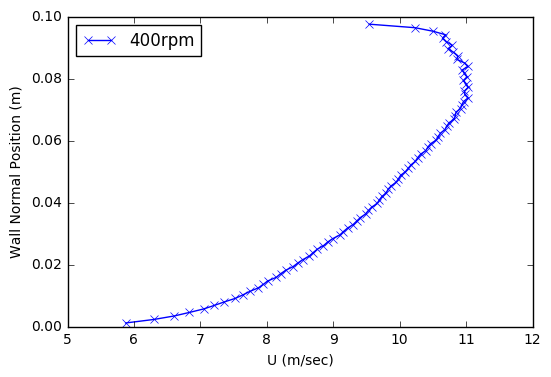

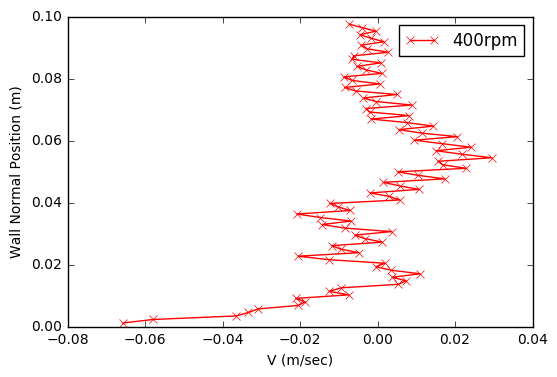

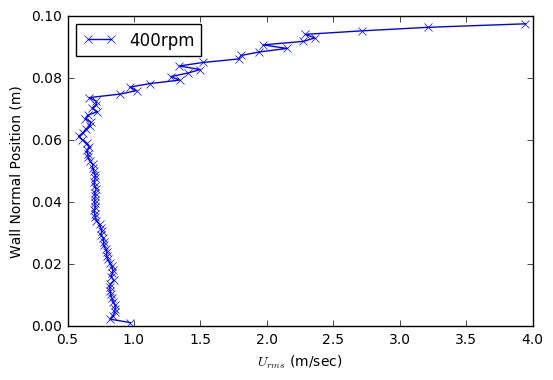

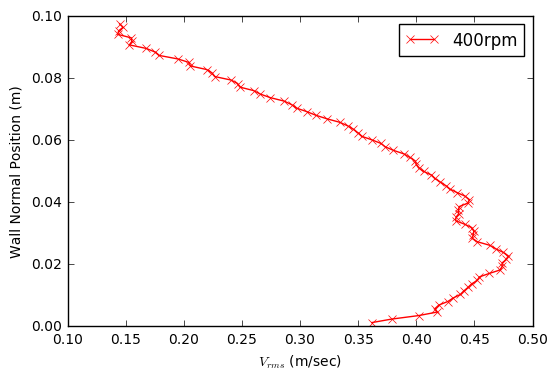

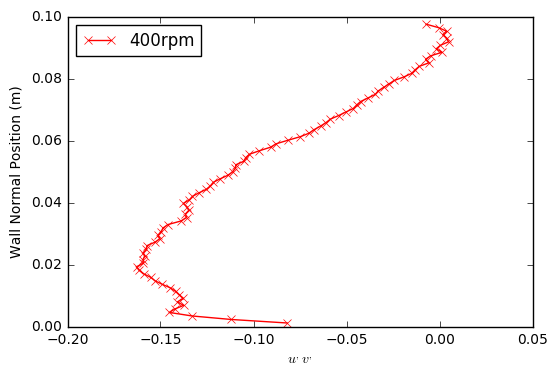

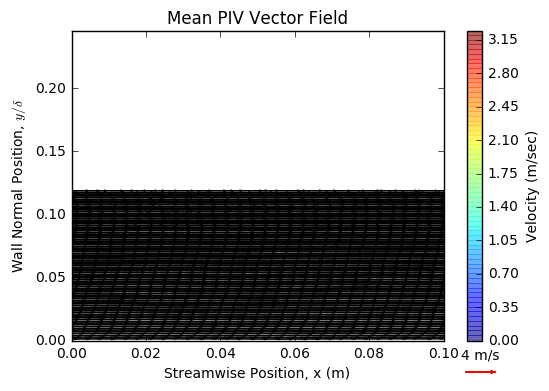

Done!


In [5]:
date = 'adrian'
num_tests = 1
piv_outer(date, num_tests)

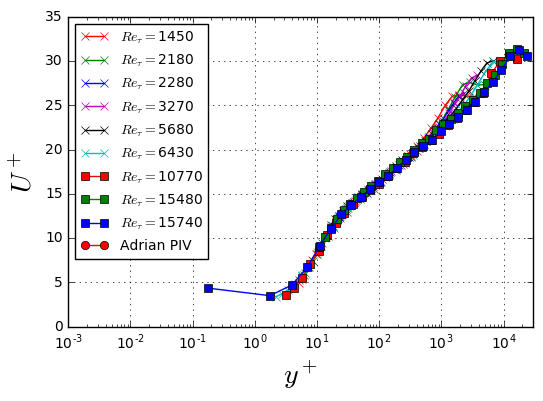

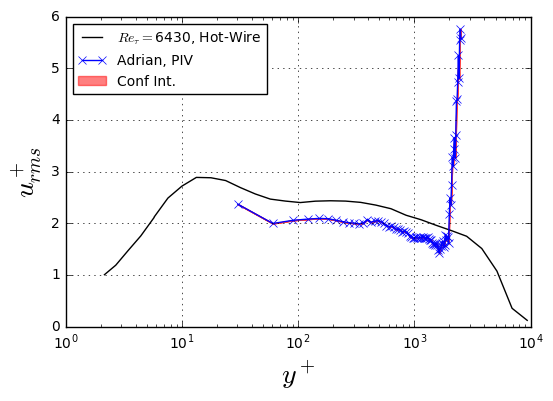

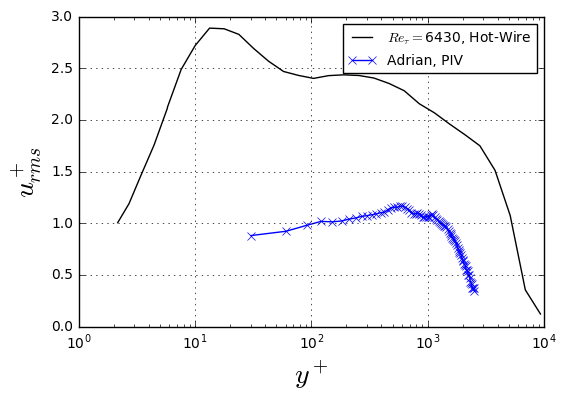

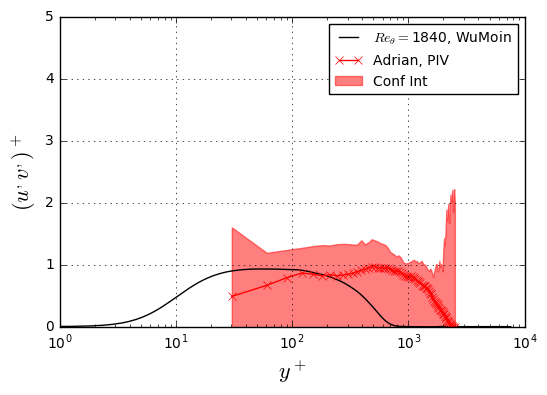

In [6]:
date = 'adrian'
num_tests = 1
utau = .41
piv_inner(date, num_tests, utau)

In [127]:
##READ IN
import pandas as pd
import numpy as np
import PIV as piv
import time
import sys
import h5py
from scipy.signal import medfilt
import matplotlib.pyplot as plt
import hotwire as hw

### PIV READ IN CODE ##############
####################################
#list name of data set folders
base_name = dict()
#List the base name for each test to be read in and analyzed, names taken directly from folder
base_name[0] = 'data/Cam_Date=170727_Time=103432_TR_SeqPIV_MP(2x16x16_50ov_ImgCorr)=unknown'
def piv_readin(date, file_name, base_name, num_images, data_delimiter, sizex, sizey, walloffset, side_error):
    #Initalize variables
    num_tests = len(base_name)
    u = np.ndarray([num_tests, num_images, sizey, sizex])
    v = np.ndarray([num_tests, num_images, sizey, sizex])
    v_filt = np.ndarray([num_tests, num_images, sizey, sizex])
    u_filt = np.ndarray([num_tests, num_images, sizey, sizex])
    umean = np.ndarray([num_tests, sizey, sizex])
    #vmean1 = np.ndarray([num_tests, sizey, sizex])
    #mask = np.zeros([num_tests, 3])
    umean_profile = dict()
    vmean_profile = dict()
    urms_profile = dict()
    vrms_profile = dict()
    uvprime_profile = dict()
    #determine file name
    file_name = dict()
    for j in range(1, num_images+1):
        file_name[j] = '/AMT00High' + str('{0:02}'.format(j)) + '.dat'
    for j in base_name:
        #Read in
        [x, y, u[j], v[j]] = piv.piv_readin_mod(base_name[j], file_name, data_delimiter, num_images+1, sizey, sizex)
        #calc u infinity 
        u_infinity = np.mean(u[0, 0, -10:-1, 0])
        #Filter Images
        [u_filt[j], v_filt[j], bad_im_count] = piv.filt_images(u[j], v[j], u_infinity, sizey)
        #Obtain mean vector field
        umean[j] = np.nanmean(u_filt[j, :], axis=0)
        #vmean1[j] = np.nanmean(v_filt[j, :], axis=0)

    #determine mask position
    tempmask = piv.mask_loc(umean[j])
    mask = list(tempmask)
    #use this to find the mean vel in each image, and look for bad images


    ## Resize vecotor field to crop out masked areas and
    # create new vectors which take out the masked areas and any side errors
    sizex_mask = mask[3] - mask[2] - side_error*2
    sizey_mask = mask[1] - mask[0]
    Umask = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
    Vmask = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
    umean = np.ndarray([num_tests, sizey_mask, sizex_mask])
    vmean = np.ndarray([num_tests, sizey_mask, sizex_mask])
    for j in base_name:
        Umask[j] = u_filt[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
        Vmask[j] = v_filt[j][:, mask[0]:mask[1], int(mask[2]+side_error):int(mask[3]-side_error)]
        umean[j] = np.nanmean(Umask[j], axis=0)
        vmean[j] = np.nanmean(Vmask[j], axis=0)

    ## Determine RMS quantities ##
    uprime = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
    vprime = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
    uvprime  = np.ndarray([num_tests, num_images, sizey_mask, sizex_mask])
    uvprime_mean = np.ndarray([num_tests, sizey_mask, sizex_mask])
    urms = np.ndarray([num_tests, sizey_mask, sizex_mask])
    vrms = np.ndarray([num_tests, sizey_mask, sizex_mask])
    for j in range(0, num_tests):
        for jj in range(0, num_images):
            uprime[j, jj] = ((Umask[j][jj]-umean[j]))
            vprime[j, jj] = ((Vmask[j][jj]-vmean[j]))
            uvprime[j, jj] = uprime[j, jj]*vprime[j, jj]
        uvprime_mean[j] = np.nanmean(uvprime[j], axis=0)
        urms[j] = np.nanmean(uprime[j]**2, axis=0)**(1/2)
        vrms[j] = np.nanmean(vprime[j]**2, axis=0)**(1/2)

    ## wall position adjustment ###########
    #convert to m and take off wall position as seen in images
    x = (x)/1000
    y = (y-walloffset)/1000
    xmask = x[ (mask[2]+side_error):(mask[3]-side_error) ]
    ymask = y[ mask[0]:mask[1] ]
    ## Create Mean Profiles for each data set#######
    for j in range(0, num_tests):
        umean_profile[j] = np.mean(umean[j], axis=1)
        vmean_profile[j] = np.mean(vmean[j], axis=1)
        urms_profile[j] = np.mean(urms[j], axis=1)
        vrms_profile[j] = np.mean(vrms[j], axis=1)
        uvprime_profile[j] = np.mean(uvprime_mean[j], axis=1)

    ## Average multiple profiles together
    #use this if multiple tests are performed at the same condition
    umean_profile_avg = np.zeros(len(umean_profile[0]))
    vmean_profile_avg = np.zeros(len(umean_profile[0]))
    urms_profile_avg = np.zeros(len(umean_profile[0]))
    vrms_profile_avg = np.zeros(len(umean_profile[0]))
    uvprime_profile_avg = np.zeros(len(umean_profile[0]))
    #average datasets together
    for j in range(0, num_tests):
        umean_profile_avg = umean_profile_avg + umean_profile[j]
        vmean_profile_avg = vmean_profile_avg + vmean_profile[j]
        urms_profile_avg = urms_profile_avg + urms_profile[j]
        vrms_profile_avg = vrms_profile_avg + vrms_profile[j]
        uvprime_profile_avg = uvprime_profile_avg + uvprime_profile[j]
    #divide profiles by number of tests which were combined
    umean_profile_avg = umean_profile_avg / num_tests
    vmean_profile_avg = vmean_profile_avg / num_tests
    urms_profile_avg = urms_profile_avg / num_tests
    vrms_profile_avg = vrms_profile_avg / num_tests
    uvprime_profile_avg = uvprime_profile_avg / num_tests

    ##calculate conf interval
    conf = dict()
    Neff = 75
    conf['u'] =  (np.nanmean(np.nanmean(np.nanvar(Umask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
    conf['v'] =  (np.nanmean(np.nanmean(np.nanvar(Vmask, axis=1), axis=0), axis=1))**(1/2) * (1/Neff)**(1/2)
    conf['urms'] =  (np.nanmean(np.nanvar(urms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
    conf['vrms'] =  (np.nanmean(np.nanvar(vrms, axis=0), axis=1))**(1/2) * (1/(2*Neff-1))**(1/2)
    sigma_u = (np.nanmean(np.nanvar(Umask, axis=1), axis=0))**(1/2)
    sigma_v = (np.nanmean(np.nanvar(Vmask, axis=1), axis=0))**(1/2)
    conf['uvprime'] = np.nanmean(sigma_u * sigma_v * (1+ (np.nanmean(uvprime_mean, axis=0)/(sigma_u * sigma_v))**2 / (Neff - 1))**(1/2), axis=1)

    ###  WRITE OUT DATA
    ####################
    #open hdf5 file
    hdf = pd.HDFStore('data/PIV_' + date + '.h5')
    hdf.put('umean', pd.DataFrame(umean[0]))
    hdf.put('vmean', pd.DataFrame(vmean[0]))
    hdf.put('umean_profile_avg', pd.DataFrame(umean_profile_avg))
    hdf.put('vmean_profile_avg', pd.DataFrame(vmean_profile_avg))
    hdf.put('urms_profile_avg', pd.DataFrame(urms_profile_avg))
    hdf.put('vrms_profile_avg', pd.DataFrame(vrms_profile_avg))
    hdf.put('uvprime_profile_avg', pd.DataFrame(uvprime_profile_avg))
    hdf.put('confidence', pd.DataFrame(conf))
    hdf.put('xaxis', pd.Series(xmask))
    hdf.put('yaxis', pd.Series(ymask))
    hdf.put('mask', pd.DataFrame(mask))
    hdf.close()

    print('Data Saved!')
    return

In [126]:
## PLOT OUTER 
import pandas as pd
from pandas import DataFrame
import numpy as np
import PIV
import h5py
import matplotlib.pyplot as plt
import hotwire as hw

################################################
#   PURPOSE
#   1. Compute Integral Parameters
#   2. Outer Normalize
#   3. Plot
##################################################
#note- vel and axis are flipped to properlly calc delta


def piv_outer(date, num_tests):
    #read in variables
    name = 'data/PIV_' + date + '.h5'
    umean_fov = np.array(pd.read_hdf(name, 'umean'))
    vmean_fov = np.array(pd.read_hdf(name, 'vmean'))
    umean = np.array(pd.read_hdf(name, 'umean_profile_avg'))
    vmean = np.array(pd.read_hdf(name, 'vmean_profile_avg'))
    urms = np.array(pd.read_hdf(name, 'urms_profile_avg'))
    vrms = np.array(pd.read_hdf(name, 'vrms_profile_avg'))
    uvprime = np.array(pd.read_hdf(name, 'uvprime_profile_avg'))
    x = np.array(pd.read_hdf(name, 'xaxis'))
    y = np.array(pd.read_hdf(name, 'yaxis'))
    num_tests = len(umean)

    ###1.  Outer Normalize #############
    ###################################

    ###2.  Outer Normalize #############
    ###################################

    ###3.  PLOTS ######################
    ###################################

    #mean profiles
    #U vs y
    plt.figure()
    plt.plot(umean, y, '-xb')
    plt.xlabel('U (m/sec)')
    plt.ylabel('Wall Normal Position (m)')
    plt.legend(['400rpm'], loc=0)
    plt.show()

    #V vs y
    plt.figure()
    plt.plot(vmean, y, '-xr')
    plt.xlabel('V (m/sec)')
    plt.ylabel('Wall Normal Position (m)')
    plt.legend(['400rpm'], loc=0)
    plt.show()


    #urms vs y
    plt.figure()
    plt.plot(urms, y, '-xb')
    plt.xlabel('$U_{rms}$ (m/sec)')
    plt.ylabel('Wall Normal Position (m)')
    plt.legend(['400rpm'], loc=0)
    plt.show()

    #vrms vs y
    plt.figure()
    plt.plot(vrms, y, '-xr')
    plt.xlabel('$V_{rms}$ (m/sec)')
    plt.ylabel('Wall Normal Position (m)')
    plt.legend(['400rpm'], loc=0)
    plt.show()

    #uprime vs y
    plt.figure()
    plt.plot(uvprime, y, '-xr')
    plt.xlabel('$u^,v^,$')
    plt.ylabel('Wall Normal Position (m)')
    plt.legend(['400rpm'], loc=0)
    plt.show()

    ### Mean Vecotr plot
    skip_num = 3

    umean_fov2 = umean_fov[:, 0:-1:skip_num]
    vmean_fov2 = vmean_fov[:, 0:-1:skip_num]
    x2 = x[0:-1:skip_num]
    y2 = y

    Y = np.tile(y2/.82, (len(x2), 1))
    Y = np.transpose(Y)
    X = np.tile(x2-.0543, (len(y2), 1))
    mean_fov2 = (umean_fov2**2 + vmean_fov2**2)**(1/2)

    contour_levels = np.arange(0, 3.3, .05)
    plt.figure()
    c = plt.contourf(X, Y, mean_fov2, levels = contour_levels, linewidth=40, alpha=.6)
    cbar = plt.colorbar(c)
    cbar.ax.set_ylabel('Velocity (m/sec)')
    plt.hold(True)
    q = plt.quiver(X, Y, umean_fov2, vmean_fov2, angles='xy', scale=50, width=.0025)
    p = plt.quiverkey(q, .11, -.025, 4,"4 m/s",coordinates='data',color='r')
    plt.axis([0, .1, 0, .246])
    plt.ylabel('Wall Normal Position, $y/\delta$')
    plt.xlabel('Streamwise Position, x (m)')
    plt.title('Mean PIV Vector Field')
    plt.show()
    print('Done!')
    return

In [124]:
# PLOT INNER
import pandas as pd
from pandas import DataFrame
import numpy as np
import PIV
import h5py
import matplotlib.pyplot as plt
import hotwire as hw

### PIV INNER PLOTS AND ANALYSIS ########
#########################################

def piv_inner(date, num_tests, utau):
    ################################################
    #   PURPOSE
    #   1. Inner Normalize
    #   2. PLOT
    #       uplus vs yplus
    #       urmsplus vs yplus
    #       uvprimeplus vs yplus
    ##################################################
    ##note- vel and axis are flipped to properlly calc delta

    ## Initalize variables
    conf = dict()
    # yplus = dict()
    # urmsplus = dict()
    # uvprimeplus = dict()
    #read in variables
    name = 'data/PIV_' + date + '.h5'
    umean = np.array(pd.read_hdf(name, 'umean_profile_avg'))[:-3]*-1
    vmean = np.array(pd.read_hdf(name, 'vmean_profile_avg'))[:-3]
    urms = np.array(pd.read_hdf(name, 'urms_profile_avg'))[:-3]
    vrms = np.array(pd.read_hdf(name, 'vrms_profile_avg'))[:-3]
    uvprime = np.array(pd.read_hdf(name, 'uvprime_profile_avg'))[:-3]
    x = np.array(pd.read_hdf(name, 'xaxis'))[:-3]
    y = np.array(pd.read_hdf(name, 'yaxis'))[:-3]
    conf = pd.read_hdf(name, 'confidence')[:-3]
    #air_prop = hw.air_prop(23)
    ####Vincenti data###
    name = 'data/outside_data/FPF_Vincenti_Data.h5'
    unorm = np.array(pd.read_hdf(name, 'unorm'))
    ynorm = np.array(pd.read_hdf(name, 'ynorm'))
    Re_tau = ['1450', '2180', '2280', '3270', '5680', '6430', '10770', '15480', '15740']
    urms_vincenti = pd.read_csv('data/outside_data/urmsplus_fpf_primary.csv', delimiter=',')
    yplus_vincenti = pd.read_csv('data/outside_data/yplus_fpf_primary.csv', delimiter=',')
    # ### WUMOIN DATA #######
    wumoin = dict()
    temp = pd.read_csv('data/outside_data/yplus_versus_-uv_plus_Re_1840.dat', delimiter=' ')
    temp = temp.shift(1)
    temp.columns = ['0', 'yplus','uvplus']
    temp['yplus'][0] = 0.2558821659990199
    temp['uvplus'][0] = 0.00009276450027256462
    wumoin['yplus_1840'] = temp['yplus']
    wumoin['uvplus_1840'] = temp['uvplus']
    # ## Reza Data ##
    # # #Reza PIV Velocity data
    name = 'data/outside_data/PIV_ZPG_071016.h5'
    urms_reza =np.array(pd.read_hdf(name, 'rms'))
    ynorm_reza = np.array(pd.read_hdf(name, 'yplus'))

    ### INNER NORMALIZE #
    #####################
    #approximate utau, calculated and then adjusted
    #utau = [.133]
    uplus = umean/utau
    yplus = (y*utau)/(1.538*10**(-5))
    urmsplus = urms/utau
    vrmsplus = vrms/utau
    uvprimeplus = uvprime/utau**2
    conf['uplus'] = conf['u']/utau
    conf['urmsplus'] = conf['urms']/utau
    conf['vrmsplus'] = conf['vrms']/utau
    conf['uvprimeplus'] = conf['uvprime']/utau**2

    ### Plot figure of heated and unheated PIV data
    ###############################################
    legend1 = [r'$Re_\tau=$1450', r'$Re_\tau=$2180', r'$Re_\tau=$2280', r'$Re_\tau=$3270', r'$Re_\tau=$5680', r'$Re_\tau=$6430', r'$Re_\tau=$10770', r'$Re_\tau=$15480', r'$Re_\tau=$15740', 'Adrian PIV']
    marker_V = ['-xr', '-xg', '-xb', '-xm', '-xk', '-xc', '-sr', '-sg', '-sb']
    # marker = ['-or', '-ob']
    plt.figure()
    ##Uplus Yplus
    #plot vincenti data
    for j in range(0, 9):
        plt.semilogx(ynorm[j], unorm[j], marker_V[j])
    #plot PIV data
    plt.semilogx(yplus, uplus, '-or')
    plt.fill_between(yplus, uplus[:,0], uplus[:,0] + np.array(conf['uplus']), color='r', alpha=.5)
    plt.fill_between(yplus, uplus[:,0], uplus[:,0] - np.array(conf['uplus']), color='r', alpha=.5)
    plt.legend(legend1, loc=0, fontsize=10)
    plt.ylabel('$U^+$', fontsize=20)
    plt.xlabel('$y^+$', fontsize=20)
    plt.grid(True)
    plt.axis([.001, 30000, 0, 35])
    plt.show()

    ##Urmsplus Yplus
    plt.figure()
    legend1 =  [r'$Re_\tau=$6430, Hot-Wire', r'Adrian, PIV', r'Conf Int.']
    #plt.semilogx(ynorm_reza[3][:-1], urms_reza, 'k')
    plt.semilogx(yplus_vincenti['yplus_6430'], urms_vincenti['urmsplus_6430'], 'k')
    plt.semilogx(yplus, urmsplus, '-xb')
    plt.fill_between(yplus, urmsplus[:,0], urmsplus[:,0] + np.array(conf['urmsplus']), color='r', alpha=.5)
    plt.fill_between(yplus, urmsplus[:,0], urmsplus[:,0] - np.array(conf['urmsplus']), color='r', alpha=.5)
    plt.legend(legend1, loc=0, fontsize=10)
    plt.ylabel('$u_{rms}^+$', fontsize=20)
    plt.xlabel('$y^+$', fontsize=20)
    plt.grid(True)
    #plt.axis([.001, 30000, 0, 35])
    plt.show()

    ##Vrmsplus Yplus
    plt.figure()
    legend1 =  [r'$Re_\tau=$6430, Hot-Wire', r'Adrian, PIV', r'Conf Int.']
    #plt.semilogx(ynorm_reza[3][:-1], urms_reza, 'k')
    plt.semilogx(yplus_vincenti['yplus_6430'], urms_vincenti['urmsplus_6430'], 'k')
    plt.semilogx(yplus, vrmsplus, '-xb')
    #plt.fill_between(yplus, urmsplus[:,0], urmsplus[:,0] + np.array(conf['urmsplus']), color='r', alpha=.5)
    #plt.fill_between(yplus, urmsplus[:,0], urmsplus[:,0] - np.array(conf['urmsplus']), color='r', alpha=.5)
    plt.legend(legend1, loc=0, fontsize=10)
    plt.ylabel('$u_{rms}^+$', fontsize=20)
    plt.xlabel('$y^+$', fontsize=20)
    plt.grid(True)
    #plt.axis([.001, 30000, 0, 35])
    plt.show()

    ##UVprimeplus Yplus
    legend1 =  [r'$Re_{\theta}=$1840, WuMoin', r'Adrian, PIV', r'Conf Int']
    plt.figure()
    #WuMoin
    plt.semilogx(wumoin['yplus_1840'], wumoin['uvplus_1840'], 'k')
    #PIV data
    plt.semilogx(yplus, uvprimeplus, '-xr')
    plt.fill_between(yplus, uvprimeplus[:,0], uvprimeplus[:,0] + np.array(conf['uvprimeplus']), color='r', alpha=.5)
    plt.fill_between(yplus, uvprimeplus[:,0], uvprimeplus[:,0] - np.array(conf['uvprimeplus']), color='r', alpha=.5)
    plt.legend(legend1, loc=0, fontsize=10)
    plt.ylabel('$(u^,v^,)^+$', fontsize=16)
    plt.xlabel('$y^+$', fontsize=16)
    plt.axis([1, 10000, 0, 5])
    plt.grid(True)
    plt.show()

    return